In [51]:
import os
import sys
#sys.path.insert(1, '../Src/')
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.decomposition import PCA
from umap import UMAP
from matplotlib import rcParams
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

PATH_DATA = '../../Data/'

np.random.seed(42)

%matplotlib inline

In [2]:
fname = "stringer_spontaneous.npy"
fname =os.path.join(PATH_DATA,fname)

In [3]:
# @title Data loading
dat = np.load(fname, allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# neural activity vs run

In [4]:
X = dat['sresp'].T
X.shape

(7018, 11983)

In [5]:
y = dat['run']

In [10]:
print(X[7017,:][:10])
X[7017,:].shape

[ 7.5612717 17.174635   2.8123477 15.12147   40.540108   0.
  0.         7.5029507  0.         0.       ]


(11983,)

### Normalization

In [11]:
X = (X-X.mean())/X.std()

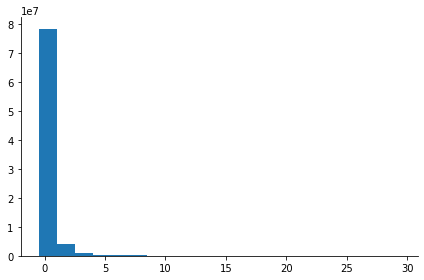

In [12]:
hist = plt.hist(X.flatten(),bins=20)

In [14]:

n = int(len(X)*0.3)

X_train = X[:-n]
y_train = y[:-n]

X_test  = X[-n:]
y_test  = y[-n:]
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


In [32]:
my_model = PCA(n_components=3000)
my_model.fit_transform(X_train)

array([[  3.6778848 , -12.186129  ,   7.1352487 , ...,  -0.9748519 ,
         -0.0794651 ,  -0.8800824 ],
       [ 26.857355  ,  -4.792169  ,  -6.4135404 , ...,   0.31198496,
          0.14838356,  -1.2103605 ],
       [ 21.189173  ,   2.2850065 ,   2.7909744 , ...,   0.8237734 ,
         -0.07169124,   0.71014476],
       ...,
       [-14.231797  , -11.633613  , -20.418125  , ...,  -0.46619448,
         -0.4549322 ,  -0.989954  ],
       [-10.246766  ,  -9.513834  , -17.668814  , ...,  -1.0359343 ,
         -0.09488682,  -0.0926573 ],
       [ -6.2721205 , -13.348963  , -13.041861  , ...,  -0.61996585,
         -0.6191868 ,  -0.9928451 ]], dtype=float32)

In [33]:
explained_variance_ratio_ = my_model.explained_variance_ratio_

In [34]:
explained_variance_ratio_[:4]

array([0.02549719, 0.0232868 , 0.01812441, 0.01412792], dtype=float32)

In [35]:
accumulate_explained_variance_ratio_ = np.cumsum(explained_variance_ratio_)

In [36]:
accumulate_explained_variance_ratio_[:4]

array([0.02549719, 0.04878399, 0.0669084 , 0.08103631], dtype=float32)

Text(0, 0.5, 'sum explained_variance_ratio')

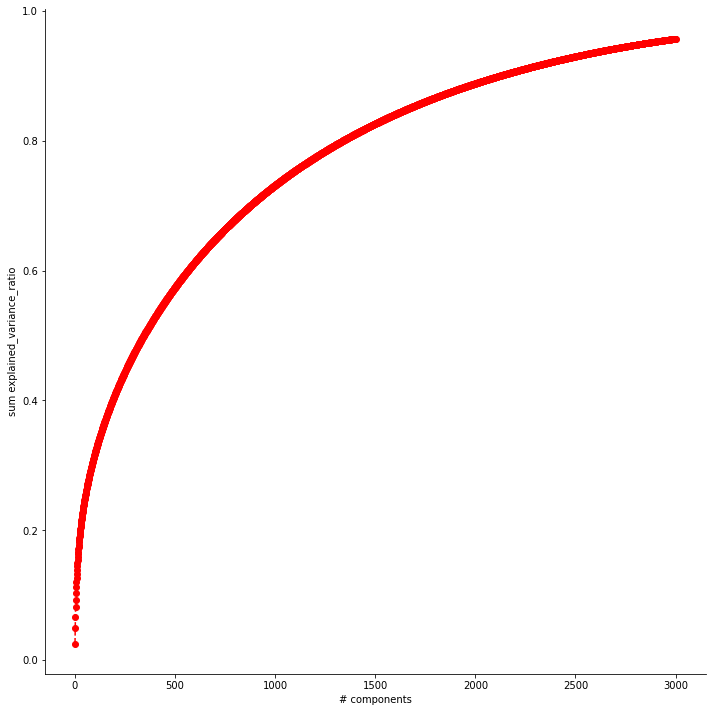

In [37]:
fig = plt.figure(figsize=(10,10))

plt.plot(range(1,len(accumulate_explained_variance_ratio_)+1),accumulate_explained_variance_ratio_,'--ro')

plt.xlabel("# components")
plt.ylabel("sum explained_variance_ratio")

In [38]:
accumulate_explained_variance_ratio_[2000]

0.8882612

In [40]:
print('Train : ',X_train.shape)
print('Test  : ',X_test.shape)

Train :  (4913, 11983)
Test  :  (2105, 11983)


In [39]:
X_train_pca = my_model.transform(X_train)
X_test_pca  = my_model.transform(X_test)

In [41]:
print('Train PCA : ',X_train_pca.shape)
print('Test PCA  : ',X_test_pca.shape)

Train PCA :  (4913, 3000)
Test PCA  :  (2105, 3000)


## Linear Regression with positive and negative coefficients

In [53]:
my_model_LR_1 = LinearRegression(positive=False)
my_model_LR_1.fit(X_train_pca,y_train)

LinearRegression()

In [64]:
y_train_pred      = my_model_LR_1.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_1.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_1.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_1.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive and negative coefficients')
plt.show()


metric_train_R2  : 0.9508766963103207
metric_train_RMSE: 1.4758989514102065
metric_test_R2  : 0.8345142841224221
metric_test_RMSE: 4.270106286498938


In [62]:
%matplotlib qt

## Linear Regression with positive coefficients

In [56]:
my_model_LR_2 = LinearRegression(positive=True)# POSITIVE = False
my_model_LR_2.fit(X_train_pca,y_train)

LinearRegression(positive=True)

In [63]:
y_train_pred      = my_model_LR_2.predict(X_train_pca) # metric_train_RMSE: 2.4037369030804003e-05


y_train_pred[y_train_pred<=0] = 0  # metric_train_RMSE: 2.196909835364599e-05


metric_train_R2   = my_model_LR_1.score(X_train_pca, y_train)
metric_train_RMSE = mean_squared_error(y_train, y_train_pred, squared=False)

print("metric_train_R2  :",metric_train_R2)
print("metric_train_RMSE:",metric_train_RMSE)

fig = plt.figure(figsize=(20,10))


plt.subplot(2,1,1)
plt.plot(range(len(y_train)),y_train,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_train_pred)),y_train_pred,'-ro',alpha=0.5,label='predicted values')

plt.legend(loc="upper left")
plt.title('Training data :  RMSE = '+str(np.round(metric_train_RMSE,2)))
#plt.show()


y_test_pred      = my_model_LR_2.predict(X_test_pca) # metric_test_RMSE: 5.73526388441703

y_test_pred[y_test_pred<=0] = 0 #metric_test_RMSE: 5.5218955408988


metric_test_R2   = my_model_LR_1.score(X_test_pca, y_test)
metric_test_RMSE = mean_squared_error(y_test, y_test_pred, squared=False)

print("metric_test_R2  :",metric_test_R2)
print("metric_test_RMSE:",metric_test_RMSE)

#fig = plt.figure(figsize=(20,5))
plt.subplot(2,1,2)
plt.plot(range(len(y_test)),y_test,'-bo',alpha=0.5,label='real values')
plt.plot(range(len(y_test_pred)),y_test_pred,'-ro',alpha=0.5,label='predicted values')
plt.title('Testing data : RMSE = '+str(np.round(metric_test_RMSE,2)))
plt.legend(loc="upper left")

plt.suptitle('Linear Regression with positive coefficients')
plt.show()


metric_train_R2  : 0.9508766963103207
metric_train_RMSE: 3.7338986133720034
metric_test_R2  : 0.8345142841224221
metric_test_RMSE: 6.117236856935283
